## TASK 2 - Image stitching

Group Number: #5

### 1. Data import and SIFT Extraction

Complete ***get_panorama_data(..)*** in _dataset.py_ to read the images and extract the SIFT keypoints and descriptors per image. Check your implementation by plotting the result using ***utils.plot_keypoints(..)***.


***Submission:*** Save the *second* image (from left) of the campus dataset as **task2_keypoints.png** using ***utils.plot_keypoints(..)***.

In [10]:
%load_ext autoreload
%autoreload 1
%aimport transforms, panorama, mapping, dataset, utils
import matplotlib.pyplot as plt
import numpy as np
import transforms
import panorama
import mapping
import dataset
import utils
import cv2

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 150

data_path = 'data/office_rot'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


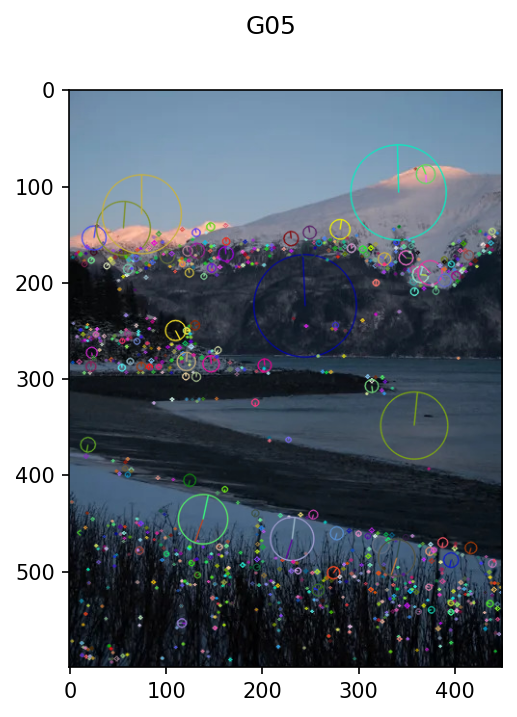

Number of images:  9
Keypoints length:  846
Descriptor shape:  (846, 128)


In [11]:
#student_code start
images, keypoints, descriptors = dataset.get_panorama_data("data/snow_complex")
utils.plot_keypoints(images[1], keypoints[1], group_no="G05", name="task2_keypoints.png")
#student_code end

# check import
print('Number of images: ',len(images))
print('Keypoints length: ', len(keypoints[0]))
print('Descriptor shape: ',descriptors[0].shape)

***
#### What is the meaning of the size of the drawn circles and lines inside the circles?

The size of the circles signifies the scale of the SIFT keypoint. A large circle means a larger feature that is farther-looking or zoomed-out , while a smaller circle means a small detailer feature. The lines inside the circles signify the orientation , SIFT keypoints show the dominat gradient direction.

#### 1.1 Matching

Let's take a look at the matching. Plot the matches between two adjacent images using ***mapping.calculate_matches(..)*** and ***utils.plot_matches(..)***.


***Submission:*** Save plot of matches between the *second and the third image* image of the campus dataset as **task2_matches.png** using ***utils.plot_matches(..)***.


Estimated homography:
 [[ 1.1721985e+00 -1.3825011e-02 -2.4463651e+02]
 [ 1.0850685e-01  1.1318903e+00 -3.8002708e+01]
 [ 4.3659681e-04  7.8861121e-06  1.0000000e+00]]
Number of inliers: 251


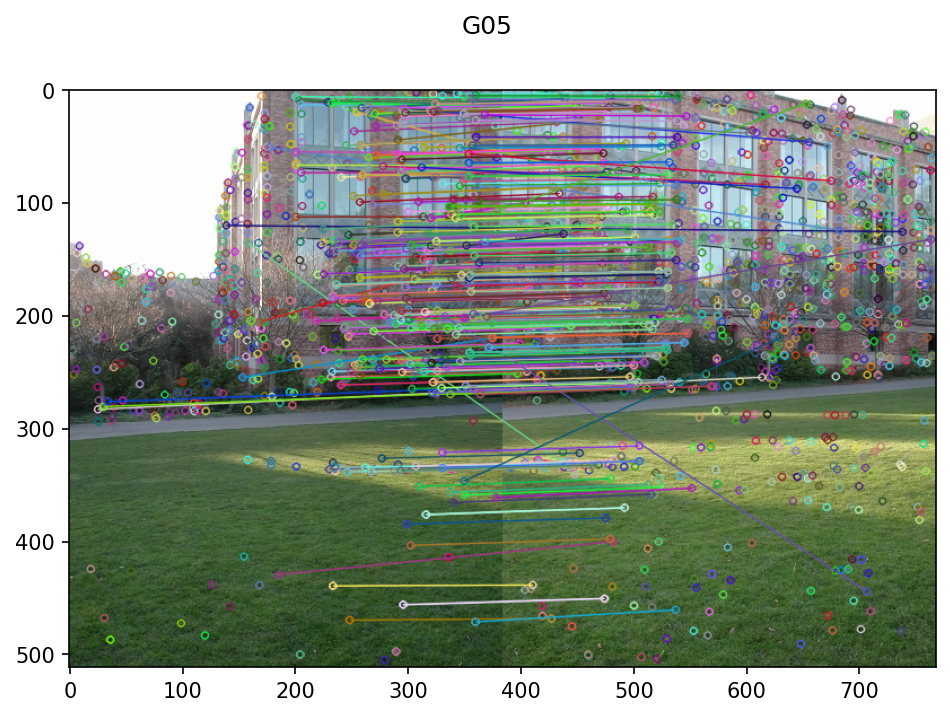

In [12]:

index1 = 1
index2 = 2

#student_code start
images, keypoints, descriptors = dataset.get_panorama_data("data/campus")

des1 = descriptors[index1]
des2 = descriptors[index2]
kp1 = keypoints[index1]
kp2 = keypoints[index2]

matches = mapping.calculate_matches(des1, des2)
homographies, inliers = transforms.get_transform(kp1, kp2, matches)

print("Estimated homography:\n", homographies)
print("Number of inliers:", len(inliers))

utils.plot_matches(images[index1], images[index2], kp1, kp2, matches, group_no="G05", name="task2_matches.png")

#student_code end

***
#### Describe below how the matching, based on LOWE, works.

LOWE works by filtering initial correspondences so only high-confidence feature matches are passed to geometry. Each SIFT descriptor is a vector of 128 numbers.
We compute the Euclidean distance from one descriptor in image 1 to all descriptors in image 2 then choose the first two closes matches and apply the LOWE ratio test , if the ratio is smaller than the treshold (in this case 0.8) it means that those matches have a clearly better best neighbours.

### 2. Image Registration using RANSAC

As you can see in the keypoint matching plot above, the matching algorithm still has some wrong connections. To remove those outliers, you will implement RANSAC and use the remaining inliers to estimate a final tranformation matrix (homography) between two given images. Implement RANSAC in ***get_transform(..)*** in _transforms.py_.

Check your implementation by plotting the result using ***utils.plot_matches(..)***.


***Submission:*** Save a plot showing the matches between the *second and the third image* of the campus dataset again, using the calculated inliers, as **task2_matches_ransac.png** using ***utils.plot_matches(..)***.

Number of matching inliers: 252


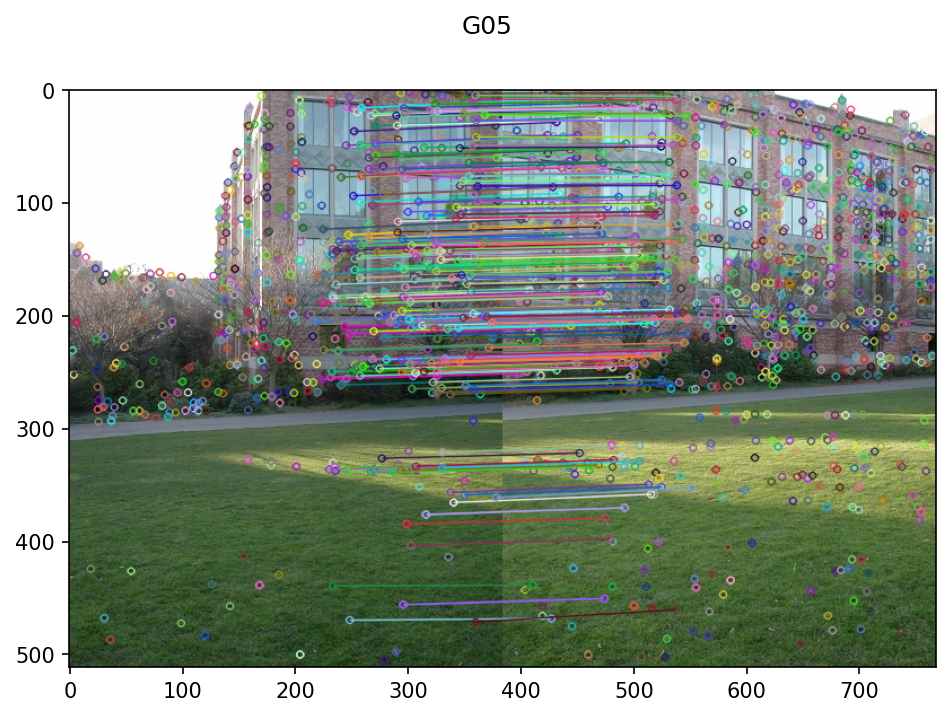

In [13]:

#student_code start
trans, inliers = transforms.get_transform(keypoints[1], keypoints[2], matches)
inlier_matches = [matches[i] for i in inliers]

print("Number of matching inliers:", len(inlier_matches))

utils.plot_matches(images[1], images[2], keypoints[1], keypoints[2], inlier_matches, "G05", "task2_matches_ransac.png")
#student_code end

***
#### What is the difference to the set of all putative matches you plotted before?

The difference is that after applying the RANSAC algorithm, the incorrect matches found by the LOWE are removed because they don't fit the estimated final transformation well.

#### 2.1 Align Images

Test your homography after RANSAC by transforming a chosen image to the corresponding image on the right and plot with ***transforms.plot_transformed_image(..)***.

_***HINT:***_
_cv2.warpPerspective(..)_


***Submission:*** Save the second image of the campus dataset transformed onto the third one as **task2_matches_transformed.png** using ***utils.plot_transformed_image(..)***.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.882353].


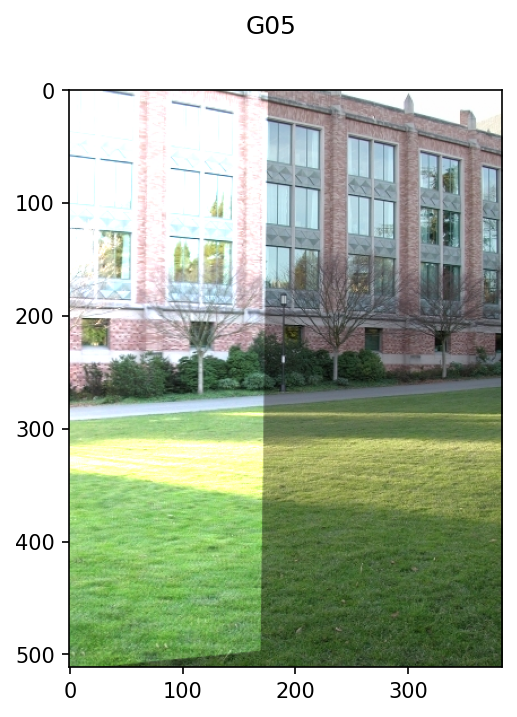

In [14]:
#student_code start
h2, w2 = images[2].shape[:2]

aligned_img1 = cv2.warpPerspective(
    images[1],       
    trans,       
    (w2, h2)    
)
ref_img_norm     = images[2].astype(np.float32) / 255.0  
aligned_img_norm = aligned_img1.astype(np.float32) / 255.0

utils.plot_transformed_image(
    ref_img_norm,
    aligned_img_norm,
    group_no="G05",
    name="task2_matches_transformed.png"
)
#student_code end

### 3. Image Stitching

Before, you implemented the basics to calculated homographies between two images. Further, transform all images to a reference image, usually the center one, to get a balanced panorama. Implement and use the method ***to_center(..)*** in _transforms.py_ to get all homographies to the center image.


In [15]:
#student_code start
H_center = transforms.to_center(descriptors, keypoints)
#student_code end

#### Panorama Extents

One final step before panorama composition is to estimate the final panorama size based on the obtained homographies. Implement ***transforms.get_panorama_extents(..)***

In [16]:
#student_code start

T, width, height = transforms.get_panorama_extents(images, H_center)

#student_code end

print("Panorama dimension: ", height, " ",width)

Panorama dimension:  737   1568


#### Simple Panorama  

Here is where the magic happens. Using the homographies, translation matrix and panorama extents, you can now stitch the images to a panorama. Implement ***panorama.get_simple(..)*** and check your result with ***utils.plot_panorama(..)***.

***Submission:*** Save the campus panorama as **task2_panorama_simple.png** using ***utils.plot_panorama(..)***.

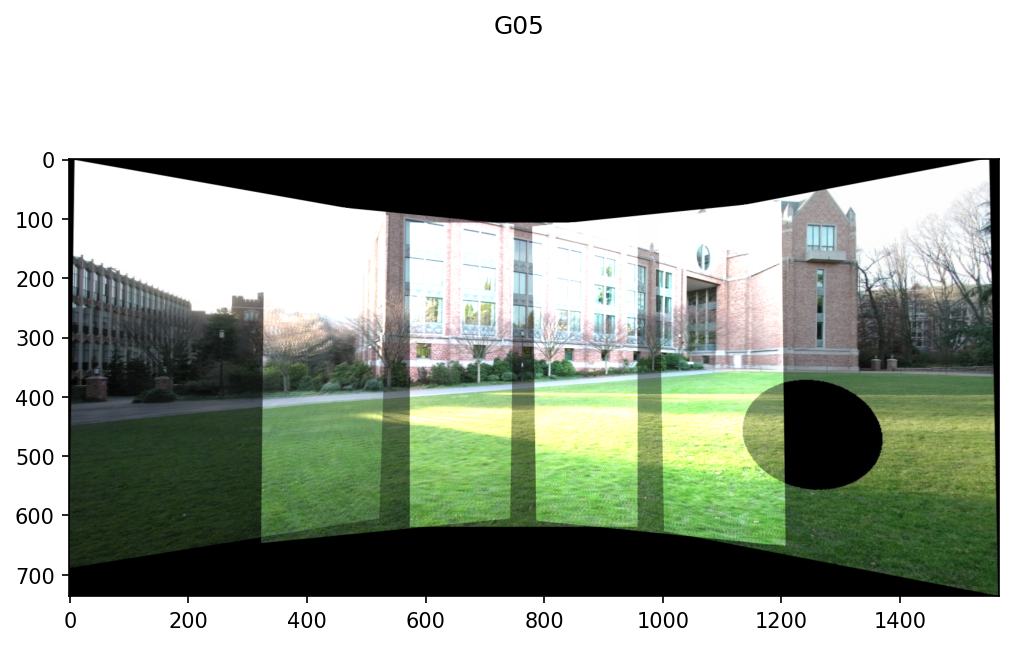

In [17]:
#student_code start

panorama_simple = panorama.get_simple(images, width, height, H_center, T)
utils.plot_panorama(panorama_simple, group_no="G05", name="task2_panorama_simple.png")

#student_code end

### 4. Panorama Feathering

The simple panorama might look geometrically correct, but not pleasant enough yet. The intensities are simply stacked. Implement a color blending method to improve the panorama output. 

Complete ***panorama.get_blended(..)*** and check your result with ***utils.plot_panorama(..)***.

***Submission:*** Save the improved blended campus panorama as **task2_panorama_blended.png** using ***utils.plot_panorama(..)***.

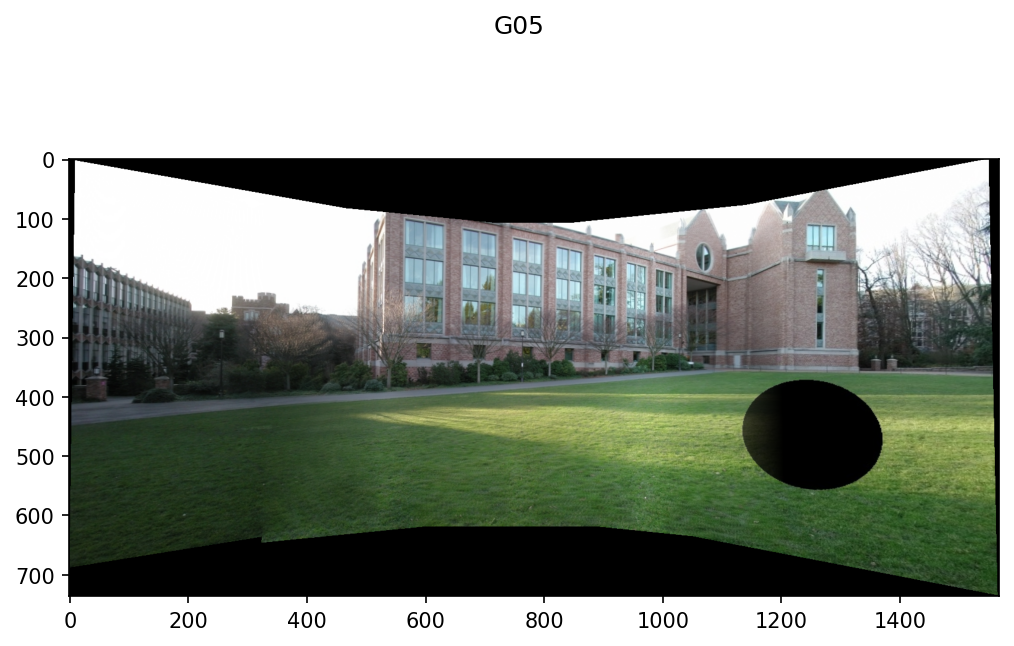

In [18]:
#student_code start
panorama_blended = panorama.get_blended(images, width, height, H_center, T)
utils.plot_panorama(panorama_blended, group_no="G05", name="task2_panorama_blended.png")
#student_code end


***
#### Compare the result achieved with feathering to the result where no blending has been performed. What is the difference of the two results?

The difference is in how overlapping pixels of the images are handled. Without blending, they are just added on top of each other, which results in bright regions and visible borders between the images that make up the panorama. With blending, the resulting pixel value is a weighted average, making the resulting panorama seem more like one cohesive big image.

***
#### Examine if the presented scheme of SIFT interest point detection and RANSAC-based alignment is invariant to changes in image rotation and scale. Thus, resize and rotate the second image of the campus dataset and repeat the panorama process. What do you observe?

***Submission:*** Save the resulting panorama with the rotated images as file ***panorama_rotated_blended.png*** (feathered)

#ANSWER HERE

***
#### Once again, repeat the panorama procedure with your own image sequence. Save and discuss the achieved results. The result might look quite realistic at a first glance but can you spot any errors by looking on details?

***Submission:*** Save the resulting panorama as file ***panorama_own.png*** (feathered) 

#ANSWER HERE